## A simple demo of Test-Time Generative Augmentation
This example is from the **polyp** dataset.

### Imports and init device

In [1]:
import warnings
warnings.filterwarnings('ignore')

import argparse
import torch
from torch.optim.adam import Adam
import torch.nn.functional as nnf
from diffusers import StableDiffusionPipeline
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import utils

parser = argparse.ArgumentParser('TTGA training and evaluation script', add_help=False)
parser.add_argument('--data', default='', type=str)
parser.add_argument('--num-aug-images', default=10, type=int)
parser.add_argument('--prompt', default='', type=str)
parser.add_argument('--resolution', default=512, type=int)
parser.add_argument('--beta-start', default=0.0001, type=float)
parser.add_argument('--beta-end', default=0.02, type=float)
parser.add_argument('--t-start', default=300, type=int)
parser.add_argument('--t-interval-denoising', default=100, type=int)
parser.add_argument('--lr', default=0.1, type=float)
parser.add_argument('--maximum-train-steps', default=1000, type=int)
parser.add_argument('--minimum-train-steps', default=100, type=int)
parser.add_argument('--early_stop_loss', default=1e-4, type=float)
parser.add_argument('--guidance-scale', default=2, type=float)
parser.add_argument('--guidance-scale-c', default=1, type=float)
parser.add_argument('--guidance-scale-r', default=0.5, type=float)
parser.add_argument('--drop-p', default=0.0, type=float)
args, _ = parser.parse_known_args()

args.device = torch.device('cuda')
args.data = 'polyp'
args.prompt = 'a photo of a polyp'

ldm_stable = StableDiffusionPipeline.from_pretrained('/home/Data/maxiao/HuggingFace/models/runwayml/stable-diffusion-v1-5').to(args.device)
ldm_stable.load_lora_weights('outputs/polyp_lora')
tokenizer = ldm_stable.tokenizer
text_encoder = ldm_stable.text_encoder
vae = ldm_stable.vae.eval()
unet = ldm_stable.unet.eval()
input_ids = tokenizer([args.prompt, ""], padding="max_length", return_tensors="pt").input_ids
text_embedding, uncond_embedding = text_encoder(input_ids.to('cuda'))[0].chunk(2)

Loading pipeline components...:  14%|█▍        | 1/7 [00:00<00:00,  6.83it/s]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 13.54it/s]


### One-step Null-Text Optimization

In [2]:
IMAGE_PATH = 'datasets/polyp/demo.png'

args.betas = torch.linspace(args.beta_start**0.5, args.beta_end**0.5, 1000, dtype=torch.float32) ** 2
args.alphas = 1.0 - args.betas
args.alphas_cumprod = torch.cumprod(args.alphas, dim=0)
timesteps_forward = torch.arange(0, args.t_start + 1, args.t_interval_denoising).to(args.device)

image = Image.open(IMAGE_PATH).resize((args.resolution, args.resolution))
original_samples = utils.image2latent(vae, image)

with torch.no_grad():
    latent_start = original_samples.clone()
    for j in range(len(timesteps_forward) - 1): 
        noise_pred_text = unet(latent_start, timesteps_forward[j], encoder_hidden_states=text_embedding)["sample"]
        latent_start = utils.add_noise(args, latent_start, noise_pred_text, timesteps_forward[j], timesteps_forward[j + 1])
    noise_pred_text = unet(latent_start, timesteps_forward[-1], encoder_hidden_states=text_embedding)["sample"]

null_text_embedding = uncond_embedding.clone().detach()
null_text_embedding.requires_grad = True
optimizer = Adam([null_text_embedding], lr=args.lr)

progress_bar = tqdm(range(args.maximum_train_steps), total=args.maximum_train_steps)
for j in progress_bar:
    noise_pred_null_text = unet(latent_start, timesteps_forward[-1], encoder_hidden_states=null_text_embedding)["sample"]
    noise_pred = noise_pred_null_text + args.guidance_scale * (noise_pred_text - noise_pred_null_text)
    pred_original_samples = utils.denoise(args, latent_start, noise_pred, timesteps_forward[-1], timesteps_forward[0], eta=0.0)

    loss = nnf.mse_loss(pred_original_samples, original_samples)
    progress_bar.set_postfix(loss=loss.item())
    if j > args.minimum_train_steps and loss.item() < args.early_stop_loss + timesteps_forward[-1] * 1e-6:
        progress_bar.close()
        break
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

 68%|██████▊   | 681/1000 [02:02<00:57,  5.55it/s, loss=0.000394]


### Masked-guided Generation

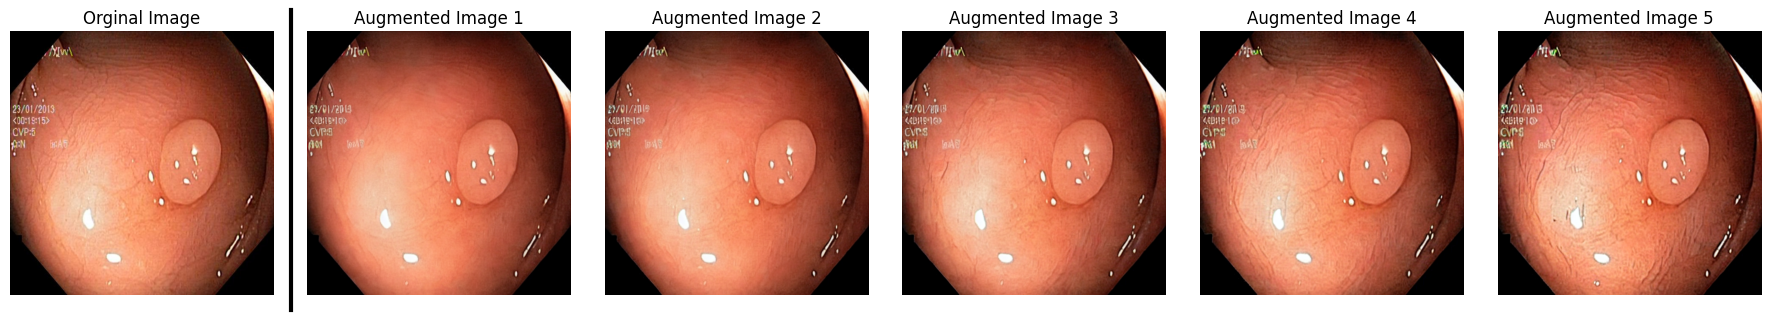

In [3]:
controller = utils.AttentionStore()
utils.register_attention_control(unet, controller)
timesteps_denoising = torch.arange(args.t_start, -1, -args.t_interval_denoising).to(args.device)
args.guidance_scale_c = 1.0
args.drop_p = 0.5

NUM_AUG_IMAGES = 5

fig, axes = plt.subplots(1, NUM_AUG_IMAGES + 1, figsize=(3 * (NUM_AUG_IMAGES + 1), 3))
axes[0].imshow(image)
axes[0].set_title('Orginal Image')
axes[0].axis('off')

r_list = np.linspace(0.5, 1.5, NUM_AUG_IMAGES)
for i in range(NUM_AUG_IMAGES):
    latent_cur = latent_start.clone()
    args.guidance_scale_r = r_list[i]
    latent_cur = utils.aug_one_image(args, controller, unet, latent_cur, timesteps_denoising, uncond_embedding, text_embedding, null_text_embedding)
    gen_aug_image = utils.latent2image(vae, latent_cur)[0]

    axes[1 + i].imshow(gen_aug_image)
    axes[1 + i].set_title(f'Augmented Image {1 + i}')
    axes[1 + i].axis('off')

plt.tight_layout()
pos1 = axes[0].get_position()
pos2 = axes[1].get_position()
line_x = (pos1.x1 + pos2.x0) / 2
line = Line2D([line_x, line_x], [0.0, 1.0], transform=fig.transFigure, color='black', linewidth=3)
fig.add_artist(line)
plt.show()